# Cardiovascular Risk Prediction

In [1]:
# Load in necessary libraries

In [3]:
import warnings
import numpy as np
import pandas as pd

import sklearn
from sklearn import impute
from sklearn import metrics
from sklearn import ensemble
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection

import numpy as np
import pandas as pd
from sklearn import impute, preprocessing

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use("ggplot")
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

In [4]:
# Load the dataset

In [7]:
from google.colab import drive; drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/data_cardiovascular_risk.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [10]:
df.head()

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


In [11]:
# Display the information about the dataset

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3390 non-null   int64  
 1   age              3390 non-null   int64  
 2   education        3303 non-null   float64
 3   sex              3390 non-null   object 
 4   is_smoking       3390 non-null   object 
 5   cigsPerDay       3368 non-null   float64
 6   BPMeds           3346 non-null   float64
 7   prevalentStroke  3390 non-null   int64  
 8   prevalentHyp     3390 non-null   int64  
 9   diabetes         3390 non-null   int64  
 10  totChol          3352 non-null   float64
 11  sysBP            3390 non-null   float64
 12  diaBP            3390 non-null   float64
 13  BMI              3376 non-null   float64
 14  heartRate        3389 non-null   float64
 15  glucose          3086 non-null   float64
 16  TenYearCHD       3390 non-null   int64  
dtypes: float64(9),

In [13]:
# Display the statistical information of the dataset¶

In [14]:
df.describe(exclude="O").T

,count,mean,std,min,25%,50%,75%,max
id,3390.0,1694.500000,978.753033,0.00,847.25,1694.50,2541.75,3389.0
age,3390.0,49.542183,8.592878,32.00,42.00,49.00,56.00,70.0
education,3303.0,1.970936,1.019081,1.00,1.00,2.00,3.00,4.0
cigsPerDay,3368.0,9.069477,11.879078,0.00,0.00,0.00,20.00,70.0
BPMeds,3346.0,0.029886,0.170299,0.00,0.00,0.00,0.00,1.0
prevalentStroke,3390.0,0.006490,0.080309,0.00,0.00,0.00,0.00,1.0
prevalentHyp,3390.0,0.315339,0.464719,0.00,0.00,0.00,1.00,1.0
diabetes,3390.0,0.025664,0.158153,0.00,0.00,0.00,0.00,1.0
totChol,3352.0,237.074284,45.247430,107.00,206.00,234.00,264.00,696.0
sysBP,3390.0,132.601180,22.292030,83.50,117.00,128.50,144.00,295.0


In [15]:
df.describe(include="O").T

,count,unique,top,freq
sex,3390,2,F,1923
is_smoking,3390,2,NO,1703


In [16]:
# Check for the presence of null

In [17]:
df.isnull().sum()

id                   0
age                  0
education           87
sex                  0
is_smoking           0
cigsPerDay          22
BPMeds              44
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             38
sysBP                0
diaBP                0
BMI                 14
heartRate            1
glucose            304
TenYearCHD           0
dtype: int64

In [18]:
def preprocess_dataset(df, scale=False):
    ## Create a copy of the dataset
    data = df.copy()

    ## Drop columns with too many unique values
    data.drop("id", axis=1, inplace=True)

    ## Bin the ages
    bins = [0, 40, 50, 60, np.inf]
    names = ['Thirties', 'Forties', 'Fifties', 'Sixties']
    data['Age'] = pd.cut(data['age'], bins, labels=names, right=False)

    ## Define a mapping from age groups to integers
    age_mapping = {'Thirties': 1, 'Forties': 2, 'Fifties': 3, 'Sixties': 4}

    ## Convert 'Age' to a string type and apply the mapping
    data['Age'] = data['Age'].map(age_mapping)

    ## Convert 'Age' into a categorical variable
    data['Age'] = data['Age'].astype('category')

    cat_var = data.select_dtypes(include=["O", "category"])
    num_var = data.select_dtypes(exclude=["O", "category"])

    ## Fill in missing values
    num_var = pd.DataFrame(impute.KNNImputer().fit_transform(num_var), columns=num_var.columns)
    cat_var =  cat_var.fillna(cat_var.median())

    ## Encode categorical columns, excluding 'Age'
    for col in cat_var.columns:
        if col != 'Age':
            cat_var[col] = preprocessing.LabelEncoder().fit_transform(cat_var[col])

    ## Concat both dataframes column wise
    data = pd.concat([cat_var, num_var], axis=1)

    ## Split data into feature and target
    feature = data.drop("TenYearCHD", axis=1)
    target = data["TenYearCHD"]

    ## Scale the dataset if the scale argument is set to True
    if scale:
        scale_columns = ['cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
        feature[scale_columns] = pd.DataFrame(preprocessing.StandardScaler().fit_transform(feature[scale_columns]), columns=scale_columns)

    return feature, target, data

# Now call the preprocess_dataset function
X, y, clean_df = preprocess_dataset(df, scale=True)



In [19]:
X.head()

,sex,is_smoking,Age,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,0,1,4,64.0,2.0,-0.512845,0.0,0.0,0.0,0.0,-0.357483,0.690879,0.176093,0.444202,1.171283,-0.086188
1,1,0,1,36.0,4.0,-0.766032,0.0,0.0,1.0,0.0,-0.557346,1.588193,1.257462,0.967609,-0.332529,-0.300821
2,0,1,2,46.0,1.0,0.077923,0.0,0.0,0.0,0.0,0.286518,-0.744824,-0.988457,-1.325645,1.004193,0.514786
3,1,1,3,50.0,1.0,0.921877,0.0,0.0,1.0,0.0,-0.091000,1.139536,0.425640,0.600007,-0.666710,0.514786
4,0,1,4,64.0,1.0,1.765831,0.0,0.0,0.0,0.0,0.086656,0.174923,0.176093,0.152068,-0.499620,-0.214968


In [20]:
# Create separate data frame for Independent Study: Age Group 4
df_sixties = clean_df[clean_df['Age'] == 4]
y_sixties = y[X['Age'] == 4]
X_sixties = X[X['Age'] == 4]

In [21]:
X_sixties.head()

,sex,is_smoking,Age,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,0,1,4,64.0,2.0,-0.512845,0.0,0.0,0.0,0.0,-0.357483,0.690879,0.176093,0.444202,1.171283,-0.086188
4,0,1,4,64.0,1.0,1.765831,0.0,0.0,0.0,0.0,0.086656,0.174923,0.176093,0.152068,-0.499620,-0.214968
5,0,0,4,61.0,3.0,-0.766032,0.0,0.0,1.0,0.0,0.775071,2.216313,3.170651,1.705248,0.753558,-0.730088
6,1,0,4,61.0,1.0,-0.766032,0.0,0.0,1.0,0.0,0.020035,4.459598,4.418384,-0.235010,-0.081894,-0.129114
10,0,0,4,61.0,1.0,-0.766032,0.0,0.0,1.0,0.0,0.926078,2.350910,3.170651,2.294386,0.335832,0.145616


In [22]:
y_sixties.head()

0     1.0
4     0.0
5     1.0
6     0.0
10    0.0
Name: TenYearCHD, dtype: float64

In [23]:
df_sixties.head()

,sex,is_smoking,Age,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,1,4,64.0,2.0,3.0,0.0,0.0,0.0,0.0,221.0,148.0,85.0,27.62,90.0,80.0,1.0
4,0,1,4,64.0,1.0,30.0,0.0,0.0,0.0,0.0,241.0,136.5,85.0,26.42,70.0,77.0,0.0
5,0,0,4,61.0,3.0,0.0,0.0,0.0,1.0,0.0,272.0,182.0,121.0,32.80,85.0,65.0,1.0
6,1,0,4,61.0,1.0,0.0,0.0,0.0,1.0,0.0,238.0,232.0,136.0,24.83,75.0,79.0,0.0
10,0,0,4,61.0,1.0,0.0,0.0,0.0,1.0,0.0,278.8,185.0,121.0,35.22,80.0,85.4,0.0


In [24]:
df_sixties.drop('age', axis=1, inplace=True)
X_sixties.drop('age', axis=1, inplace=True)
X_sixties.head()

,sex,is_smoking,Age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,0,1,4,2.0,-0.512845,0.0,0.0,0.0,0.0,-0.357483,0.690879,0.176093,0.444202,1.171283,-0.086188
4,0,1,4,1.0,1.765831,0.0,0.0,0.0,0.0,0.086656,0.174923,0.176093,0.152068,-0.499620,-0.214968
5,0,0,4,3.0,-0.766032,0.0,0.0,1.0,0.0,0.775071,2.216313,3.170651,1.705248,0.753558,-0.730088
6,1,0,4,1.0,-0.766032,0.0,0.0,1.0,0.0,0.020035,4.459598,4.418384,-0.235010,-0.081894,-0.129114
10,0,0,4,1.0,-0.766032,0.0,0.0,1.0,0.0,0.926078,2.350910,3.170651,2.294386,0.335832,0.145616


In [25]:
df_sixties.head()

,sex,is_smoking,Age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,1,4,2.0,3.0,0.0,0.0,0.0,0.0,221.0,148.0,85.0,27.62,90.0,80.0,1.0
4,0,1,4,1.0,30.0,0.0,0.0,0.0,0.0,241.0,136.5,85.0,26.42,70.0,77.0,0.0
5,0,0,4,3.0,0.0,0.0,0.0,1.0,0.0,272.0,182.0,121.0,32.80,85.0,65.0,1.0
6,1,0,4,1.0,0.0,0.0,0.0,1.0,0.0,238.0,232.0,136.0,24.83,75.0,79.0,0.0
10,0,0,4,1.0,0.0,0.0,0.0,1.0,0.0,278.8,185.0,121.0,35.22,80.0,85.4,0.0


In [26]:
# Drop 'Age'
df_sixties.drop('Age', axis=1, inplace=True)
y_sixties = y[X['Age'] == 4]
X.drop('Age', axis=1, inplace=True)

train_data = pd.concat([df_sixties, y_sixties], axis=1)

In [27]:
train_data

,sex,is_smoking,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,TenYearCHD
0,0,1,2.0,3.0,0.0,0.0,0.0,0.0,221.0,148.0,85.0,27.62,90.0,80.0,1.0,1.0
4,0,1,1.0,30.0,0.0,0.0,0.0,0.0,241.0,136.5,85.0,26.42,70.0,77.0,0.0,0.0
5,0,0,3.0,0.0,0.0,0.0,1.0,0.0,272.0,182.0,121.0,32.80,85.0,65.0,1.0,1.0
6,1,0,1.0,0.0,0.0,0.0,1.0,0.0,238.0,232.0,136.0,24.83,75.0,79.0,0.0,0.0
10,0,0,1.0,0.0,0.0,0.0,1.0,0.0,278.8,185.0,121.0,35.22,80.0,85.4,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3374,1,1,2.0,60.0,0.0,0.0,1.0,0.0,261.0,170.0,100.0,22.71,72.0,79.0,1.0,1.0
3381,0,0,1.0,0.0,0.0,0.0,0.0,0.0,205.0,138.0,71.0,33.11,60.0,85.0,1.0,1.0
3384,0,0,1.0,0.0,0.0,0.0,1.0,0.0,217.0,182.0,86.0,26.98,105.0,113.0,0.0,0.0
3385,0,0,1.0,0.0,0.0,0.0,0.0,0.0,261.0,123.5,79.0,29.28,70.0,103.0,0.0,0.0


In [28]:
# Exploratory Data Analysis

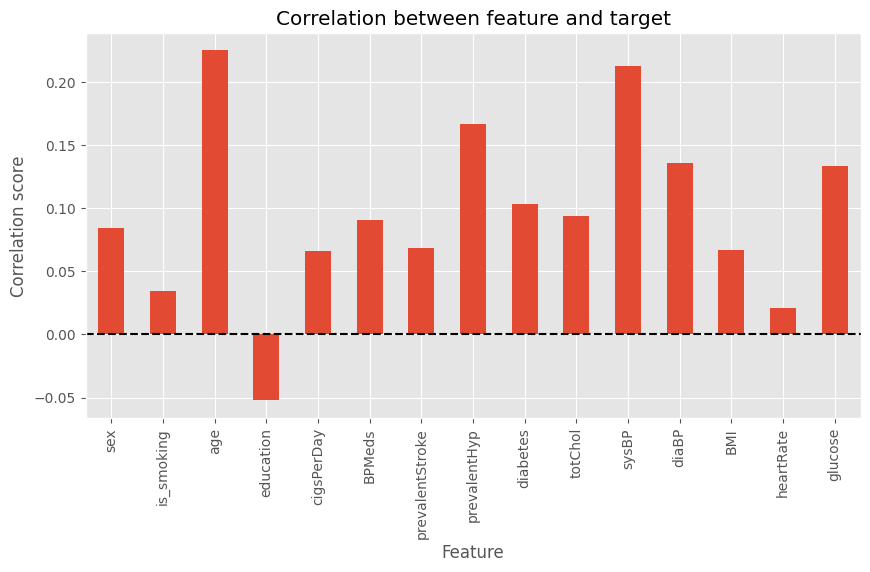

In [29]:
X['TenYearCHD'] = y

## Calculate and plot the correlation
corr_fig = X.corr()["TenYearCHD"].drop('TenYearCHD').plot(kind="bar", figsize=(10, 5))
corr_fig.axhline(color="k", ls="--")
corr_fig.set_title("Correlation between feature and target")
corr_fig.set_xlabel("Feature")
corr_fig.set_ylabel("Correlation score")

plt.show()

## Remove 'TenYearCHD' from the features dataframe
X.drop('TenYearCHD', axis=1, inplace=True)


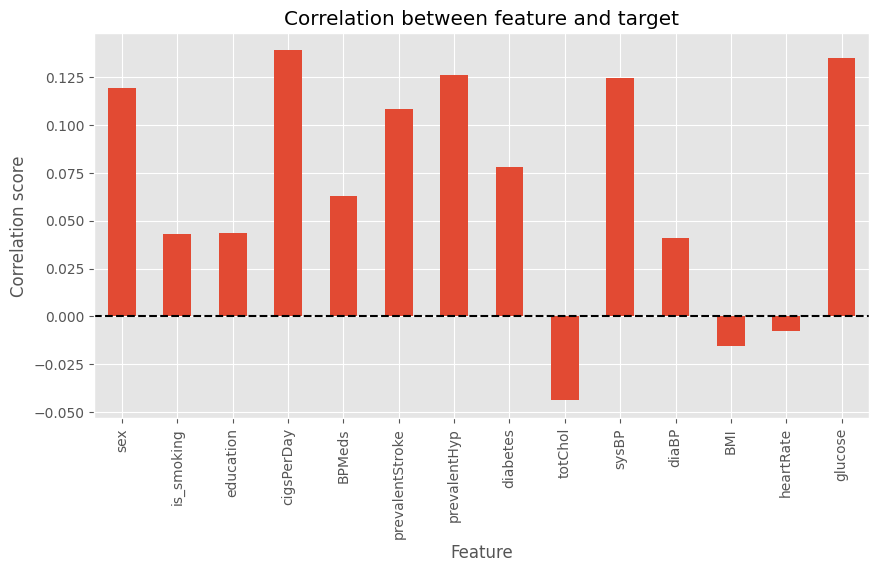

In [30]:
df_sixties['TenYearCHD'] = y_sixties

## Calculate and plot the correlation
corr_fig = df_sixties.corr()["TenYearCHD"].drop('TenYearCHD').plot(kind="bar", figsize=(10, 5))
corr_fig.axhline(color="k", ls="--")
corr_fig.set_title("Correlation between feature and target")
corr_fig.set_xlabel("Feature")
corr_fig.set_ylabel("Correlation score")

plt.show()


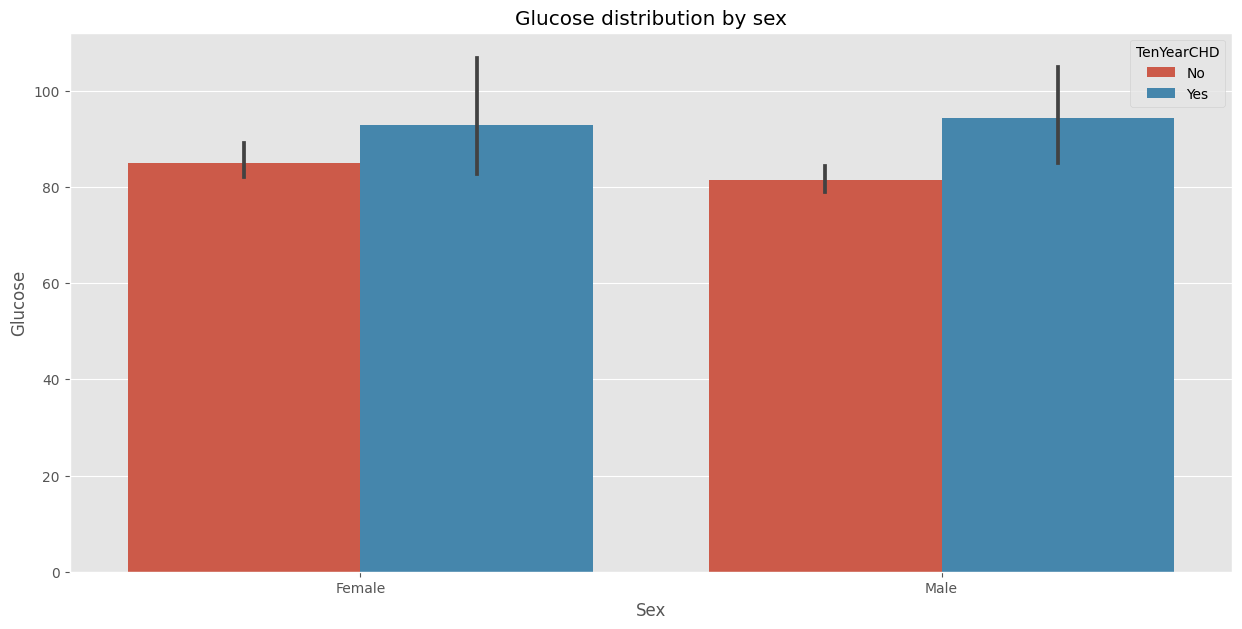

In [31]:
plt.figure(figsize=(15, 7))
sns.barplot(data=df_sixties, x="sex", y="glucose", hue="TenYearCHD")
plt.xlabel("Sex")
plt.ylabel("Glucose")
plt.xticks([0, 1], ["Female", "Male"])
plt.title("Glucose distribution by sex")

# Modify Legend
handles, label = plt.gca().get_legend_handles_labels()

plt.legend(handles, ["No", "Yes"], title="TenYearCHD")

plt.show()


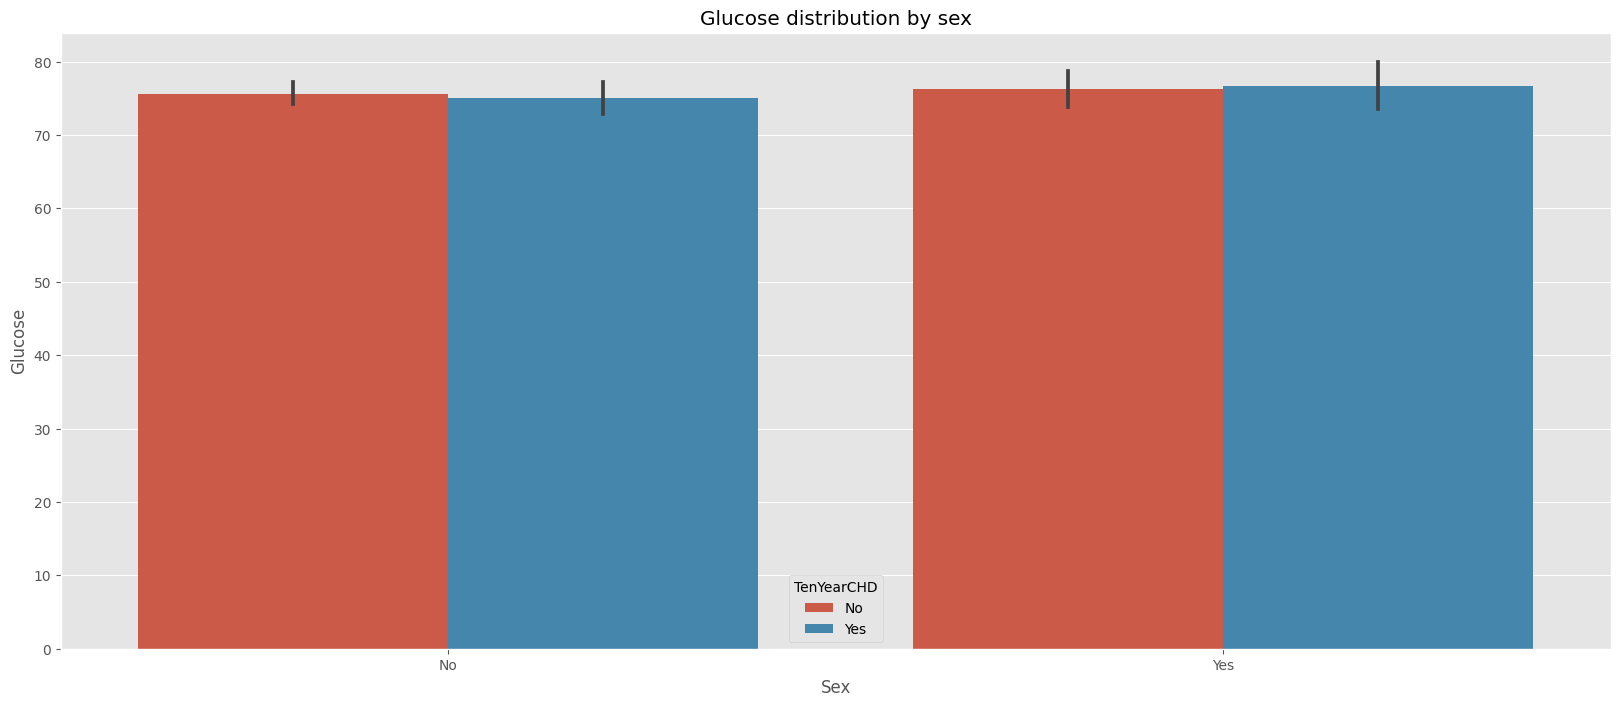

In [32]:
plt.figure(figsize=(20, 8))
sns.barplot(data=df_sixties, x="is_smoking", y="heartRate", hue="TenYearCHD")
plt.xlabel("Sex")
plt.ylabel("Glucose")
plt.xticks([0, 1], ["No", "Yes"])
plt.title("Glucose distribution by sex")

handles, label = plt.gca().get_legend_handles_labels()
plt.legend(handles, ["No", "Yes"], title="TenYearCHD")

plt.show()

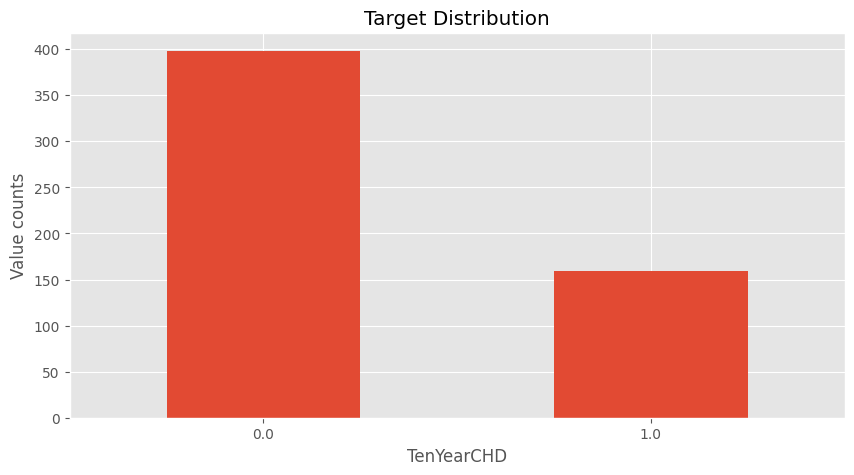

In [33]:
fig = df_sixties["TenYearCHD"].value_counts().plot(kind="bar", rot=0, figsize=(10, 5))

fig.set_title("Target Distribution")
fig.set_xlabel("TenYearCHD")
fig.set_ylabel("Value counts")

plt.show()

In [34]:
# Split Data into train and test dataset

In [35]:
def split_data(df):

    Xtrain, Xtest, Ytrain, Ytest = model_selection.train_test_split(df.drop("TenYearCHD", axis=1),
                                                                    df["TenYearCHD"], test_size=.2,
                                                                    random_state=0,
                                                                    stratify=df["TenYearCHD"])

    Xtrain.reset_index(drop=True, inplace=True)
    Xtest.reset_index(drop=True, inplace=True)
    Ytrain.reset_index(drop=True, inplace=True)
    Ytest.reset_index(drop=True, inplace=True)

    return Xtrain, Xtest, Ytrain, Ytest

In [36]:
## Split the data for the _sixties variant
xtrain_sixties, xtest_sixties, ytrain_sixties, ytest_sixties = split_data(df_sixties)


In [37]:
# Modeling

In [38]:
list_of_models = [linear_model.LogisticRegression, ensemble.RandomForestClassifier]

In [39]:
def train_model(X, y, X_valid, y_valid, lst_of_model, fold=5):

    final_prediction_per_model = pd.DataFrame()
    final_score_per_model = pd.DataFrame(index=["Accuracy score"])

    for model in lst_of_model:
        m = model()
        model_prediction = pd.DataFrame()
        performance = []

        for idx, train_test_idx in enumerate(model_selection.StratifiedKFold(n_splits=fold).split(X, y)):
            x_train, x_test = X.loc[train_test_idx[0]], X.loc[train_test_idx[1]]
            y_train, y_test = y[train_test_idx[0]], y[train_test_idx[1]]

            # Fit the model
            m.fit(x_train, y_train)

            test_pred = m.predict(x_test)
            val_pred = m.predict(X_valid)

            model_prediction[f"fold{idx}"] = val_pred

            performance.append(metrics.accuracy_score(y_test, test_pred))

        final_score_per_model[model.__name__] = [np.mean(performance)]
        final_prediction_per_model[model.__name__] = model_prediction.mode(axis=1)[0]

    return final_prediction_per_model, final_score_per_model.T

In [40]:
# Call the train_model function with the _sixties variants
predictions_sixties, score_sixties = train_model(xtrain_sixties, ytrain_sixties, xtest_sixties, ytest_sixties, list_of_models)

In [41]:
predictions_sixties

,LogisticRegression,RandomForestClassifier
0,0.0,0.0
1,0.0,0.0
2,1.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
107,0.0,0.0
108,0.0,0.0
109,0.0,0.0
110,0.0,0.0


In [42]:
# Model Evaluation

In [43]:
def print_classification_report(pred, ytest):
    col = list(pred.columns)

    print(f"Classification Report for {col[0]} Model\n")
    print(metrics.classification_report(pred[col[0]], ytest))

    print("="*60, end="\n\n")

    print(f"Classification Report for {col[1]} Model\n")
    print(metrics.classification_report(pred[col[1]], ytest))

    return

In [44]:
print_classification_report(predictions_sixties, ytest_sixties)

Classification Report for LogisticRegression Model

              precision    recall  f1-score   support

         0.0       0.97      0.74      0.84       105
         1.0       0.16      0.71      0.26         7

    accuracy                           0.74       112
   macro avg       0.57      0.73      0.55       112
weighted avg       0.92      0.74      0.81       112


Classification Report for RandomForestClassifier Model

              precision    recall  f1-score   support

         0.0       0.96      0.73      0.83       105
         1.0       0.12      0.57      0.21         7

    accuracy                           0.72       112
   macro avg       0.54      0.65      0.52       112
weighted avg       0.91      0.72      0.79       112

